# Exploratory Research of Object Recognition Based on Deep Learning and Single image Super Resolution

## License and Source Code References
* The code in the document by Erik Linder-Norén and Magnus Erik Hvass Pedersen is licensed under the MIT License https://opensource.org/licenses/MIT
* Availability: https://github.com/Hvass-Labs/TensorFlow-Tutorials and https://github.com/eriklindernoren/Keras-GAN

## Prerequisite 

* Python version should be 3.0+. Check your python version. Open an terminal and type in python --version. If you only have 2.7 installed. Install python 3.0+. From https://www.python.org/downloads/mac-osx/. Here is a useful guide: http://docs.python-guide.org/en/latest/starting/install3/osx/
* Install the latest Anaconda. Here is a useful guide: https://conda.io/docs/user-guide/install/index.html
* To connect to google cloud platform you need to Install mysql. Open an terminal and use pip3 install mysql
* Install tensorflow. Open terminal and pip3 install tensorflow
* Install prettytensor. Open terminal and pip3 install prettytensor
* Install keras. Open terminal and pip3 install keras
* Download TensorFlow-Tutorials-master from from https://github.com/Hvass-Labs/TensorFlow-Tutorials. After downloading, uncompress all the files.
* Download helper.py from https://github.com/lishahan/CSYE7245_2018Spring/tree/master/FinalProject and put it in TensorFlow-Tutorials-master folder.
* Download data from this shared link https://drive.google.com/file/d/1NAJislaACkY0cw8HpINT_b1nc0vroBbj/view?usp=sharing ,uncompress it and put it in TensorFlow-Tutorials-master folder.
* Download cifar10 from https://www.cs.toronto.edu/~kriz/cifar.html, uncompress it and put the folder in TensorFlow-Tutorials-master folder.
* Create google cloud platform account and link your credit card. 
* Create instance on google cloud platform.
* Create a database named ImageLabel under the instance.
* Download google platform sdk and install it here is an useful guide: https://cloud.google.com/sdk/downloads. Initialize and authorize by open terminal and type in gcloud init


In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
import prettytensor as pt
import mysql.connector
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import csv
import datetime
import time
import re
import statsmodels.api as sm
import mysql
from prettytable import PrettyTable
import itertools
from itertools import chain
from PIL import Image
import imagehash
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from PIL import Image
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras import optimizers

## Part1 Data Processing

### 1. Download dataset and store the label and image address information in a table of the data base created on Google Cloud Platform

In [83]:
label1= pd.read_csv("trainLabels.csv", sep=',')

In [84]:
list_col=['ImageID','LabelName','Type','ImageAddr']

In [85]:
df=pd.DataFrame(columns=list_col)

In [86]:
df['ImageID']=label1['id']
df['LabelName']=label1['label']
df['Type']=label1['id']

#### Split training data to 1:4

In [87]:
df.loc[df['ImageID']<=40000, 'Type'] = 'train'
df.loc[df['ImageID']>40000, 'Type'] = 'test'

In [88]:
# type in your local path for creating database on the cloud
path_local='/Users/lisha/Desktop/'

In [89]:
for i in range(len(df)):
    df.loc[i,'ImageAddr']=path_local + 'train/'+ str(i+1) +'.png'

#### Save the processed dataset to local txt file for creating database

In [90]:
df.to_csv(path_local+"ImageLabel.txt", sep=',',index=False, )

#### Open terminal to start proxy past this command: "./cloud_sql_proxy -instances=bd7245-200622:us-east1:image-category-184805=tcp:3306 &"

In [96]:
cnx = mysql.connector.connect(user='root', password='GoHusky!',
                              host='127.0.0.1',
                              database='ImageLabel')
c=cnx.cursor()

#### Create table with training and testing image information

In [97]:
sql = """CREATE TABLE ImageLabel_local (ImageID int NOT NULL, LabelName  CHAR(20) NOT NULL, Type CHAR(10) NOT NULL, ImageAddr CHAR(255) NOT NULL)"""
c.execute(sql)

In [100]:
query = "LOAD DATA LOCAL INFILE '/Users/lisha/Desktop/ImageLabel.txt' INTO TABLE ImageLabel_local FIELDS TERMINATED BY ','  Lines Terminated BY '\n' (ImageID,LabelName,Type,ImageAddr)"
c.execute( query )
cnx.commit()

In [105]:
# A function to print returned data in a better form
def print_table(c):
    rows=c.fetchall()
    pt = PrettyTable([i[0] for i in c.description])
    pt.align= "l"
    for row in rows:
        pt.add_row(row)
    print (pt)

In [115]:
# Database I created
c.execute("""SELECT * FROM ImageLabel_local LIMIT 10""")
print_table(c)

+---------+------------+-------+----------------------------------+
| ImageID | LabelName  | Type  | ImageAddr                        |
+---------+------------+-------+----------------------------------+
| 0       | LabelName  | Type  | ImageAddr                        |
| 1       | frog       | train | /Users/lisha/Desktop/train/1.png |
| 2       | truck      | train | /Users/lisha/Desktop/train/2.png |
| 3       | truck      | train | /Users/lisha/Desktop/train/3.png |
| 4       | deer       | train | /Users/lisha/Desktop/train/4.png |
| 5       | automobile | train | /Users/lisha/Desktop/train/5.png |
| 6       | automobile | train | /Users/lisha/Desktop/train/6.png |
| 7       | bird       | train | /Users/lisha/Desktop/train/7.png |
| 8       | horse      | train | /Users/lisha/Desktop/train/8.png |
| 9       | ship       | train | /Users/lisha/Desktop/train/9.png |
+---------+------------+-------+----------------------------------+


### 2. Process data to suitable set for tensorflow

In [116]:
# This function is used to de-tuple list of tuples
def tuple_list(tuplelist):
    return list(itertools.chain(*tuplelist))

#### Get images and label lists with label name cat&dog

In [123]:
c=cnx.cursor()
c.execute("""SELECT LabelName FROM ImageLabel_local WHERE LabelName='cat' OR LabelName='dog'""")
list_label_cat_dog=tuple_list(c.fetchall())

In [129]:
c=cnx.cursor()
c.execute("""SELECT ImageAddr FROM ImageLabel_local WHERE LabelName='cat' OR LabelName='dog'""")
list_file_cat_dog=tuple_list(c.fetchall())

#### Get cifar2 from training images downloaded from https://www.cs.toronto.edu/~kriz/cifar.html

In [132]:
import cifar10
import helper
from dataset import one_hot_encoded

#### Set image size, chanels, cropped image size, and classes of images

In [133]:
img_size=32
num_channels=3
num_classes=10
img_size_cropped=32

In [134]:
list_label_cat_dog[:5]

[3, 3, 3, 3, 5]

#### Change names of class to numbers 0 to 9, here cat is 3 and dog is 5

In [140]:
for i in range(len(list_label_cat_dog)):
    if list_label_cat_dog[i]=='cat':
        list_label_cat_dog[i]=3
    else:
        list_label_cat_dog[i]=5

In [145]:
cls2=np.array(list_label_cat_dog)

In [146]:
list_file_cat_dog[:5]

['/Users/lisha/Desktop/train/10.png',
 '/Users/lisha/Desktop/train/18.png',
 '/Users/lisha/Desktop/train/22.png',
 '/Users/lisha/Desktop/train/27.png',
 '/Users/lisha/Desktop/train/28.png']

#### Get images and labels for the training set.

In [153]:
list_raw=[]
for image in list_file_cat_dog:
    img = Image.open(image)
    data = list(img.getdata())
    list_raw.append(tuple_list(data))

In [157]:
raw_images=np.array(list_raw)
images2 = cifar10._convert_images(raw_images)
images_train=images2

In [162]:
labels_train=one_hot_encoded(class_numbers=cls2, num_classes=num_classes)

#### Get test data set from cifar10

In [167]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [173]:
t=pd.DataFrame({'img':l, 'lab':l1, 'cls': l2})

In [177]:
t1=t.loc[t['cls'] == 3]
t2=t.loc[t['cls'] == 5]
frame=pd.concat([t1,t2])

In [184]:
img_test=np.array(list(frame['img']))
lab_test=np.array(list(frame['lab']))
cl_test=np.array(list(frame['cls']))

In [185]:
def change_contrast(img, level):
    img=Image.fromarray(img, 'RGB')
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return img.point(contrast)

In [193]:
list_distorted=[]
for img in img_test:
    list_distorted.append(change_contrast(img,300))

In [200]:
list_dis=[]
for i in range(len(list_distorted)):
    im = list_distorted[i]
    pixels = tuple_list(list(im.getdata()))
    list_dis.append(pixels)
raw_images_test_distorted=np.array(list_dis)
images_test_distorted=cifar10._convert_images(raw_images_test_distorted)

## Part2 Exploring possibility of using single image super resolution in image classification

### 1. Build a GAN model 

In [203]:
#This is a function to save the outcome of the model
#Create folder named gan on your loacal path 
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(path_local+"gan/test_%d.png" % epoch)
    plt.close()

#### Build generator

In [204]:
img_row=28
img_col=28
channel=1
img_shape=(img_row, img_col, channel)

In [205]:
adam = optimizers.Adam(0.0002, 0.5)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

In [207]:
model = Sequential()
model.add(Flatten(input_shape=img_shape))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(1, activation='sigmoid'))
img = Input(shape=img_shape)
validity = model(img)
discriminator = Model(img, validity)

In [208]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
__________

#### Build descriminator

In [215]:
discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [222]:
noise_shape = (100,)
model = Sequential()
model.add(Dense(256, input_shape=noise_shape))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(np.prod(img_shape), activation='tanh'))
model.add(Reshape(img_shape))
noise = Input(shape=noise_shape)
img = model(noise)
generator=Model(noise, img)

In [224]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
__________

In [225]:
generator.compile(loss='binary_crossentropy', optimizer=adam)

In [226]:
z = Input(shape=(100,))
img = generator(z)

In [231]:
discriminator.trainable = False
valid = discriminator(img)

In [235]:
combined = Model(z, valid)

In [240]:
combined.compile(loss='binary_crossentropy', optimizer=adam)

In [250]:
batch_size=128
sample_interval=200
epochs=20000

In [251]:
(X_train, _), (_, _) = mnist.load_data()

In [252]:
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

In [253]:
X_train = np.expand_dims(X_train, axis=3)

In [254]:
half_batch = int(batch_size / 2)

In [255]:
for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
    gen_imgs = generator.predict(noise)

            # Train the discriminator
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

    noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
    valid_y = np.array([1] * batch_size)

            # Train the generator
    g_loss = combined.train_on_batch(noise, valid_y)

            # Plot the progress
    if epoch%100==0:
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
    if epoch % sample_interval == 0:
        save_imgs(epoch)

/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.663746, acc.: 57.81%] [G loss: 0.853895]
100 [D loss: 0.681108, acc.: 55.47%] [G loss: 0.812665]
200 [D loss: 0.682910, acc.: 54.69%] [G loss: 0.796585]
300 [D loss: 0.693084, acc.: 57.81%] [G loss: 0.792890]
400 [D loss: 0.686184, acc.: 61.72%] [G loss: 0.814104]
500 [D loss: 0.701206, acc.: 53.12%] [G loss: 0.801902]
600 [D loss: 0.677471, acc.: 54.69%] [G loss: 0.827875]
700 [D loss: 0.655582, acc.: 64.06%] [G loss: 0.827676]
800 [D loss: 0.679052, acc.: 55.47%] [G loss: 0.855005]
900 [D loss: 0.654717, acc.: 65.62%] [G loss: 0.831815]
1000 [D loss: 0.688097, acc.: 52.34%] [G loss: 0.822470]
1100 [D loss: 0.669232, acc.: 56.25%] [G loss: 0.796239]
1200 [D loss: 0.692695, acc.: 55.47%] [G loss: 0.832457]
1300 [D loss: 0.651168, acc.: 63.28%] [G loss: 0.859824]
1400 [D loss: 0.687863, acc.: 52.34%] [G loss: 0.824491]
1500 [D loss: 0.708880, acc.: 53.12%] [G loss: 0.834695]
1600 [D loss: 0.675896, acc.: 60.16%] [G loss: 0.863795]
1700 [D loss: 0.684242, acc.: 60.94%] [G lo

14400 [D loss: 0.664124, acc.: 59.38%] [G loss: 0.852268]
14500 [D loss: 0.693459, acc.: 51.56%] [G loss: 0.782643]
14600 [D loss: 0.672899, acc.: 57.03%] [G loss: 0.827770]
14700 [D loss: 0.704666, acc.: 50.00%] [G loss: 0.812799]
14800 [D loss: 0.710695, acc.: 50.78%] [G loss: 0.832777]
14900 [D loss: 0.690029, acc.: 56.25%] [G loss: 0.838905]
15000 [D loss: 0.710372, acc.: 43.75%] [G loss: 0.793908]
15100 [D loss: 0.657281, acc.: 63.28%] [G loss: 0.804505]
15200 [D loss: 0.683959, acc.: 53.91%] [G loss: 0.835965]
15300 [D loss: 0.651350, acc.: 65.62%] [G loss: 0.812140]
15400 [D loss: 0.684502, acc.: 57.03%] [G loss: 0.816391]
15500 [D loss: 0.657761, acc.: 60.94%] [G loss: 0.798077]
15600 [D loss: 0.669524, acc.: 58.59%] [G loss: 0.842110]
15700 [D loss: 0.693964, acc.: 57.03%] [G loss: 0.796573]
15800 [D loss: 0.708712, acc.: 51.56%] [G loss: 0.814982]
15900 [D loss: 0.662717, acc.: 60.16%] [G loss: 0.762536]
16000 [D loss: 0.685597, acc.: 53.91%] [G loss: 0.794018]
16100 [D loss:

In [258]:
from PIL import Image
from matplotlib.image import imread
imageA=imread(path_local+"gan/test_0.png")

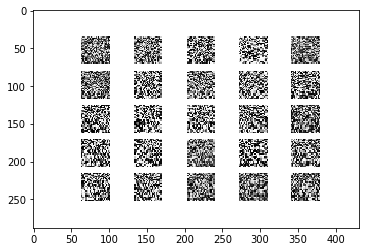

In [259]:
plt.imshow(imageA)

In [260]:
imageB=imread(path_local+"gan1/test_19800.png")

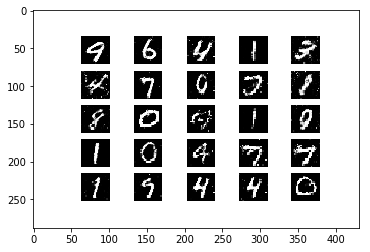

In [261]:
plt.imshow(imageB)

## Part 3 Build a CNN model using tensorflow

In [321]:
def main_network(images, training):
    x_pretty = pt.wrap(images)
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer        
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='layer_fc1').\
            fully_connected(size=128, name='layer_fc2').\
            softmax_classifier(num_classes=num_classes, labels=y_true)
    return y_pred, loss

In [322]:
def create_network(training):
    with tf.variable_scope('network', reuse=tf.AUTO_REUSE):
        images = x
        images = pre_process(images=images)
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

In [323]:
def pre_process_image(image):
    image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, max_delta=0.05)
    image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_saturation(image, lower=0.0, upper=2.0)
    image = tf.minimum(image, 1.0)
    image = tf.maximum(image, 0.0)
    return image
def pre_process(images):
    images = tf.map_fn(lambda image: pre_process_image(image), images)
    return images
def predict_cls(images, labels, cls_true):
    num_images = len(images)
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    i = 0
    while i < num_images:
        j = min(i + batch_size, num_images)
        feed_dict = {x: images[i:j, :],y_true: labels[i:j, :]}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j
    correct = (cls_true == cls_pred)    
    return correct, cls_pred
def get_test_acc(batch_size, images_test):
    correct, cls_pred = predict_cls(images = images_test, labels = lab_test, cls_true = cl_test)
    acc, num_correct = correct.mean(), correct.sum()
    num_images = len(correct)
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))
    return acc

In [443]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable
def get_acc(train_batch_size, images_train, labels_train):
    start_time = time.time()
    RUN=True
    l_accuracy=[]
    l_step=[]
    l_time=[]
    batch_acc=0
    for i in range(num_iterations):
        #w1=get_weights_variable(layer_name='layer_conv1')
        #w2=get_weights_variable(layer_name='layer_conv2')
        tf.summary.scalar('accuracy', accuracy)
        #tf.summary.histogram('weights1',w1)
        #tf.summary.histogram('weights2',w2)
        x_batch, y_true_batch = helper.random_batch(train_batch_size, images_train, labels_train)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        i_global, _ = session.run([global_step, optimizer], feed_dict=feed_dict_train)#global step
        
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            batch_acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))
            s=session.run(summary, feed_dict=feed_dict_train)
            summary_writer.add_summary(s,i)
               
        l_accuracy.append(batch_acc)
        l_step.append(i_global)
        l_time.append(time.time())
        
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    return l_accuracy, l_step, time_dif, l_time

### 1. Train the CNN model and optimize variables during traing.

In [515]:
path_board='/Users/lisha/Desktop/tensor_board/'

In [516]:
train_batch_size = 64
num_iterations=10000

In [517]:
tf.reset_default_graph()

In [518]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

In [519]:
global_step = tf.Variable(initial_value=0, name='global_step')
_, loss = create_network(training=True)
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)
y_pred, _ = create_network(training=False)
y_pred_cls = tf.argmax(y_pred, dimension=1)
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
session = tf.Session()


In [520]:
w = tf.Variable(tf.truncated_normal([5,5,3,64], stddev=0.1),name="w")
b = tf.Variable(tf.constant(0.1,shape=[64]), name="b")

In [521]:
init_op = tf.global_variables_initializer()
session.run(init_op)

In [522]:
summary = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter(path_board+'original_1')
summary_writer.add_graph(session.graph)

In [523]:
l_acc_1, l_step_1, t_diff_1, l_time_1=get_acc(train_batch_size=train_batch_size, images_train=images_train, labels_train=labels_train)

Global Step:    100, Training Batch Accuracy:  67.2%
Global Step:    200, Training Batch Accuracy:  65.6%
Global Step:    300, Training Batch Accuracy:  57.8%
Global Step:    400, Training Batch Accuracy:  59.4%
Global Step:    500, Training Batch Accuracy:  62.5%
Global Step:    600, Training Batch Accuracy:  62.5%
Global Step:    700, Training Batch Accuracy:  53.1%
Global Step:    800, Training Batch Accuracy:  45.3%
Global Step:    900, Training Batch Accuracy:  64.1%
Global Step:   1000, Training Batch Accuracy:  53.1%
Global Step:   1100, Training Batch Accuracy:  64.1%
Global Step:   1200, Training Batch Accuracy:  68.8%
Global Step:   1300, Training Batch Accuracy:  53.1%
Global Step:   1400, Training Batch Accuracy:  71.9%
Global Step:   1500, Training Batch Accuracy:  48.4%
Global Step:   1600, Training Batch Accuracy:  65.6%
Global Step:   1700, Training Batch Accuracy:  57.8%
Global Step:   1800, Training Batch Accuracy:  68.8%
Global Step:   1900, Training Batch Accuracy: 

### 2. Get test accuracy

In [525]:
batch_size = 256 
t1=get_test_acc(batch_size=batch_size, images_test=img_test)

Accuracy on Test-Set: 54.6% (1092 / 2000)


### 3. Get accuracy of distorted images

In [532]:
batch_size = 256 
t_t=get_test_acc(batch_size=batch_size,images_test=images_test_distorted)

Accuracy on Test-Set: 49.6% (993 / 2000)


## Part 4 Use SRGAN pre-processed dataset to train the CNN model

### Not implemented yet. Just a few steps away.

In [474]:
def get_layer_output(layer_name):
    tensor_name = "network/" + layer_name + "/Relu:0"
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor

In [475]:
output_conv1 = get_layer_output(layer_name='layer_conv1')
output_conv2 = get_layer_output(layer_name='layer_conv2')